# Se utiliza el siguiente dataset: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). El objetivo es construir un modelo utilizando una de las variantes de Naive Bayes para predecir si una persona tiene una enfermedad cardíaca.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import warnings
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from scipy import stats
from sklearn import metrics

warnings.filterwarnings("ignore")

file = "https://raw.githubusercontent.com/Mafasamo/PortafolioML/refs/heads/main/Naive%20Bayes/heart.csv"

raw_data = pd.read_csv(file)
raw_data.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Los modelos de Naive Bayes se basan en el teorema de Bayes, el cual estipula lo siguiente:
$P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$, donde:
  *   $P(A∣B)$ es la probabilidad de que el evento $A$ ocurra dado que se ha observado la evidencia $B$.
  *   $P(B∣A)$ es la probabilidad de que se observe la evidencia $B$ dado que el evento $A$ ha ocurrido.
  *   $P(A)$ y $P(B)$ son las probabilidades marginales de que ocurran los eventos $A$ y $B$, respectivamente.

El término Naive hace referencia a la asunción de que las variables predictoras son independientes entre sí.


## Preprocesamiento:

Se verifica el número total de valores nulos y se muestra la información del conjunto de entrenamiento.

In [ ]:
total_nulls = raw_data.isnull().sum().sum()
print("Número total de valores nulos en el DataFrame:", total_nulls)

target = raw_data[['HeartDisease']].copy()
raw_data = raw_data.drop(["HeartDisease"], axis=1)
columns = raw_data.columns

X_train, X_test, y_train, y_test = train_test_split(raw_data, target, test_size=0.2, random_state=42, shuffle=True)
X_train.info()

Número total de valores nulos en el DataFrame: 0
<class 'pandas.core.frame.DataFrame'>
Index: 734 entries, 795 to 102
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 68.8+ KB


Se identifican las columnas categóricas en el conjunto de datos de entrenamiento y se utiliza OneHotEncoding para convertirlas en variables binarias. A continuación, se reemplazan las columnas categóricas originales en los conjuntos de entrenamiento y prueba con sus versiones codificadas.

In [ ]:
# Identificar columnas categóricas
categorical_columns = X_train.select_dtypes(include=['object']).columns

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar las columnas categóricas
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_columns])

encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_columns)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Eliminar las columnas categóricas originales de X_train y X_test
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)
columns = X_train.columns
X_train.head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
795,42,120,240,1,194,0.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
25,36,130,209,0,178,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
84,56,150,213,1,125,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
10,37,130,211,0,142,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
344,51,120,0,1,104,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


Hay varias variantes de Naive Bayes, incluyendo:

*   Naive Bayes Gaussiano: Supone que las variables siguen una distribución gaussiana (normal).
*   Naive Bayes Multinomial: Adecuado para clasificación con variables discretas.
*   Naive Bayes Bernoulli: Similar a Naive Bayes Multinomial pero supone variables binarias.
*   Naive Bayes Complement: Una modificación de Naive Bayes Multinomial que es particularmente efectiva para conjuntos de datos desequilibrados.
*   Naive Bayes Categórico: Adecuado para variables categóricas con más de dos niveles.

Se realiza la prueba de normalidad Shapiro-Wilk para cada uno de los atributos en X_train. Esta prueba evalúa si los datos de cada atributo siguen una distribución normal. Para cada columna, se calcula el estadístico de la prueba (stat) y el p-valor (p). El p-valor ayuda a determinar si se puede rechazar la hipótesis nula de que los datos siguen una distribución normal.

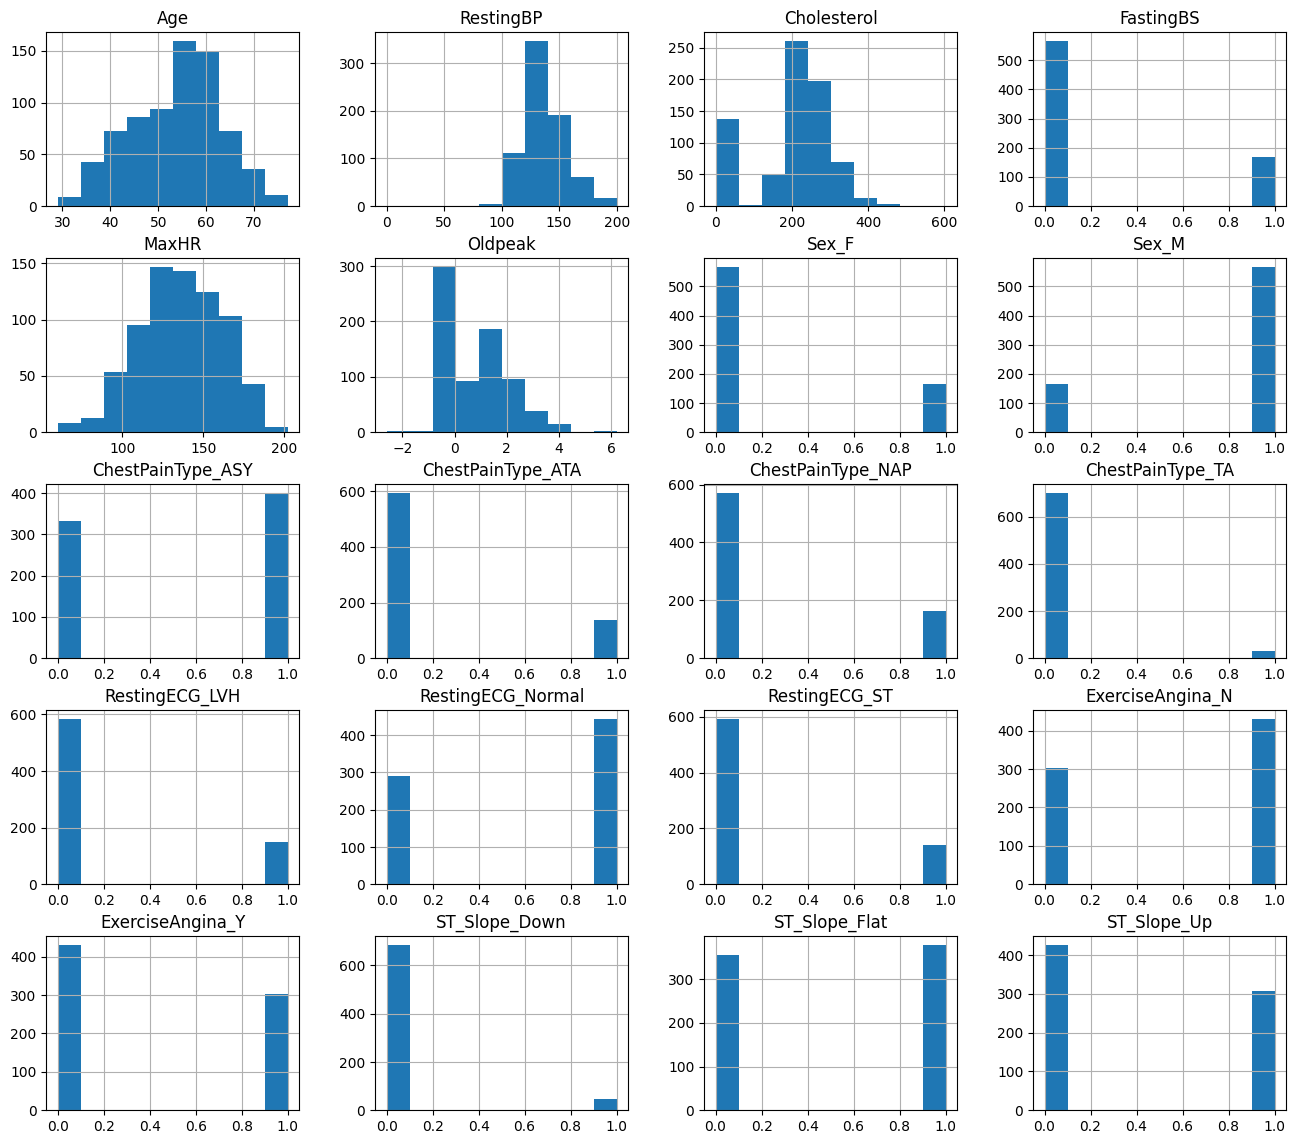

Atributo: Age, p-valor: 0.00022957579023653827
Atributo: RestingBP, p-valor: 7.283446741105708e-15
Atributo: Cholesterol, p-valor: 9.853356158352512e-25
Atributo: FastingBS, p-valor: 1.363554072317661e-40
Atributo: MaxHR, p-valor: 0.0008552183686055365
Atributo: Oldpeak, p-valor: 2.293510397509774e-25
Atributo: Sex_F, p-valor: 1.247688560277504e-40
Atributo: Sex_M, p-valor: 1.2476885602768443e-40
Atributo: ChestPainType_ASY, p-valor: 8.276925922654047e-37
Atributo: ChestPainType_ATA, p-valor: 9.565405646641626e-42
Atributo: ChestPainType_NAP, p-valor: 8.707904433362358e-41
Atributo: ChestPainType_TA, p-valor: 5.0232770555733855e-48
Atributo: RestingECG_LVH, p-valor: 2.574682684828013e-41
Atributo: RestingECG_Normal, p-valor: 2.7777234464380453e-37
Atributo: RestingECG_ST, p-valor: 1.1704072743661352e-41
Atributo: ExerciseAngina_N, p-valor: 4.220238368293478e-37
Atributo: ExerciseAngina_Y, p-valor: 4.22023836828859e-37
Atributo: ST_Slope_Down, p-valor: 8.367264841779439e-47
Atributo: ST

In [ ]:
# Histogramas de los atributos en el conjunto de entrenamiento
X_train.hist(figsize=(16, 14))
plt.show()

# Tests estadísticos (Shapiro-Wilk) para verificar la normalidad de los atributos
for column in X_train.columns:
  stat, p = stats.shapiro(X_train[column].dropna())
  print(f"Atributo: {column}, p-valor: {p}")


Los resultados del test de normalidad indican que la mayoría de los atributos en el conjunto de datos no siguen una distribución normal, ya que los p-valores son extremadamente bajos (menores a 0.05 en casi todos los casos), por lo que se rechaza la hipótesis nula.
Debido a esto, se propondrá un algoritmo Naive Bayes con ciertas características de la variante Multinomial.
Por lo tanto, como el modelo trabajará sobre variables discretas, será necesario discretizar todas los atributos. Para ello, se utilizara el metodo de clustering K-means. Con el fin de determinar el k óptimo a utilizar en el algoritmo K-means, se utilizarán los métodos "Elbow curve" y "Silhouette score".


*   Elbow curve: Para cada valor de k (número de clusters), se calcula el valor de Inertia del conjunto: $\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$, donde:

  *   $k$ es el número de clusters,
  *   $C_i$ es el conjunto de puntos en el clúster $i$,
  *   $||x - \mu_i||^2$ es la distancia euclidiana al cuadrado entre un punto $x$ y su centroide $μ_i$
 . <br>

   A continuación, se grafican los valores de Inertia en función de los diferentes valores de k. Podrá apreciarse que a medida que aumenta la cantidad de cluesters, la Inertia disminuye. Sin embargo, la reducción de la Inertia es cada vez màs pequeña con cada cluster que se agrega. El objetivo de este método es lograr encontrar el k a partir del cual un aumento en la cantidad de clusters ya no significa una reducción importante en el valor de Inertia.
*   Silhouette score: El silhouette score de un punto es una medida de cuán similar es a su propio clúster en comparación con otros clústers.
Para cada punto i en el conjunto de datos, se calcula el silhouette score de la siguiente manera: $s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$, donde:
  *   $s(i)$ es el silhouette score de i,
  *   $b(i)$ es la distancia promedio entre el punto i y los otros puntos en el mismo cluster,
  *   $a(i)$ es la distancia promedio entre el punto i y los puntos en el clúster más cercano diferente al clúster al que i pertenece. <br>

  A continuación, se calcula el silhouette score promedio del conjunto de datos: <br>
    *   $\text{Silhouette Score} = \frac{1}{N} \sum_{i=1}^{N} s(i)$
  
  El número óptimo de clusters se elige maximizando el puntaje de silhouette score promedio.

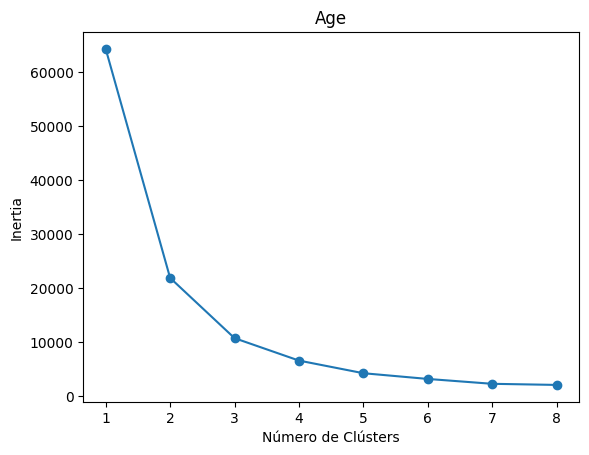

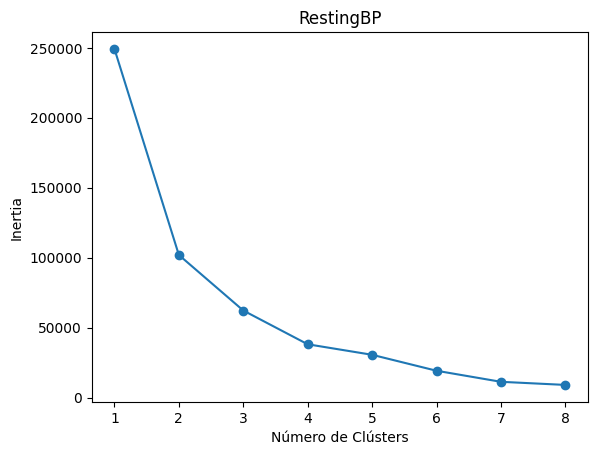

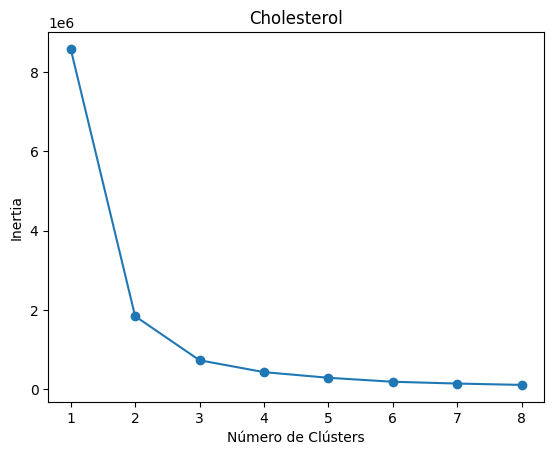

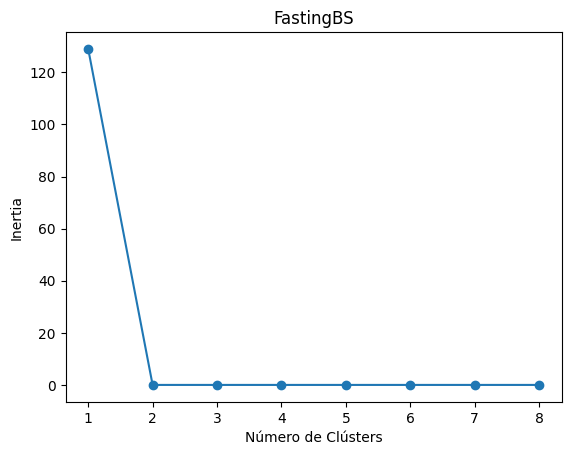

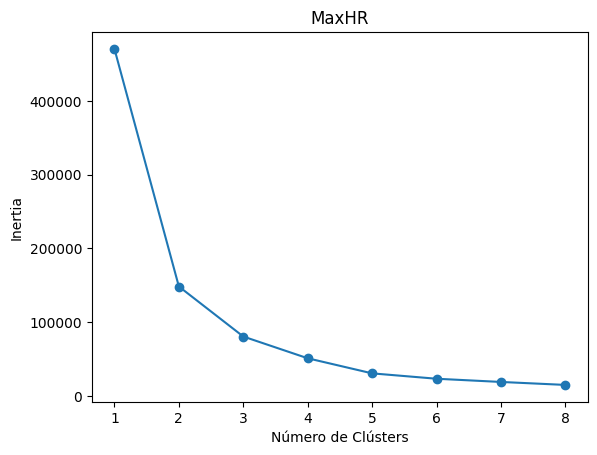

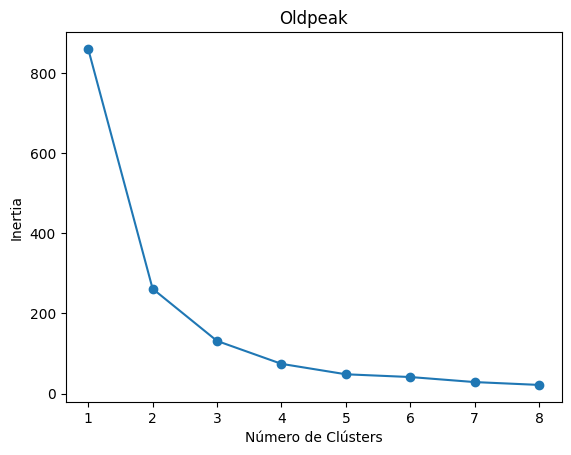

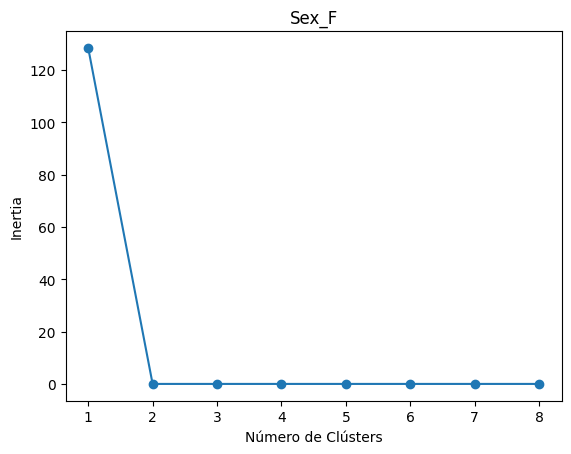

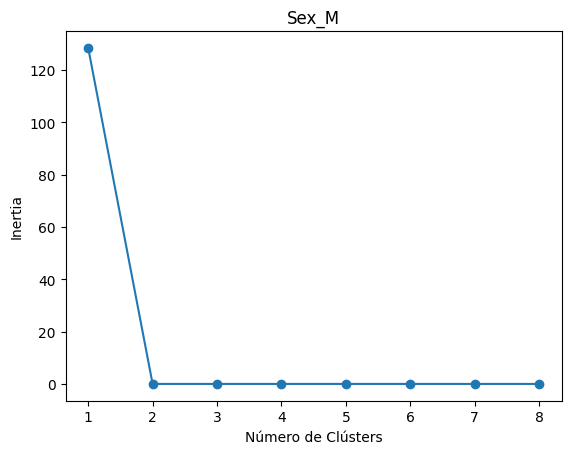

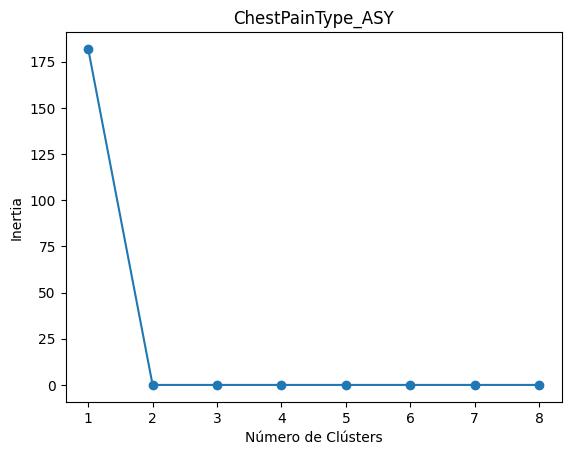

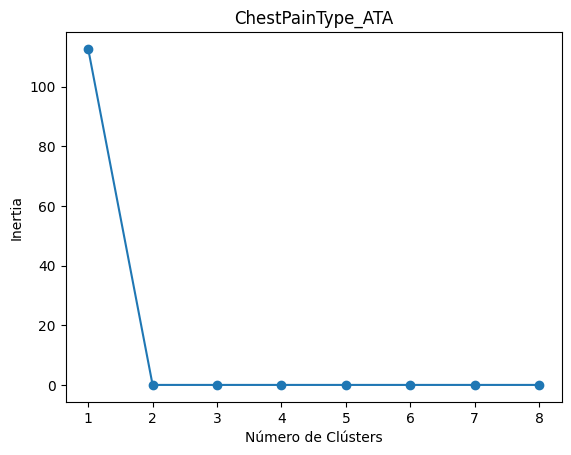

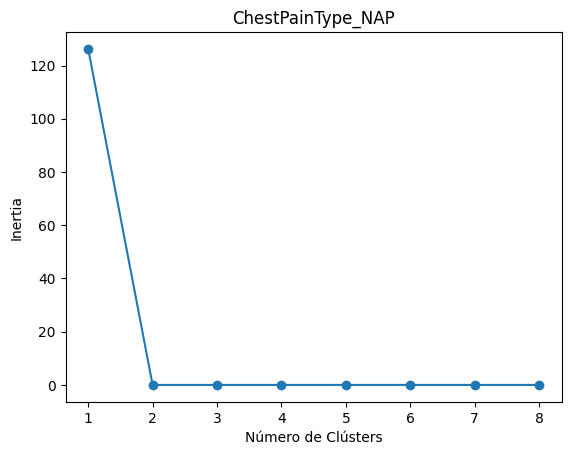

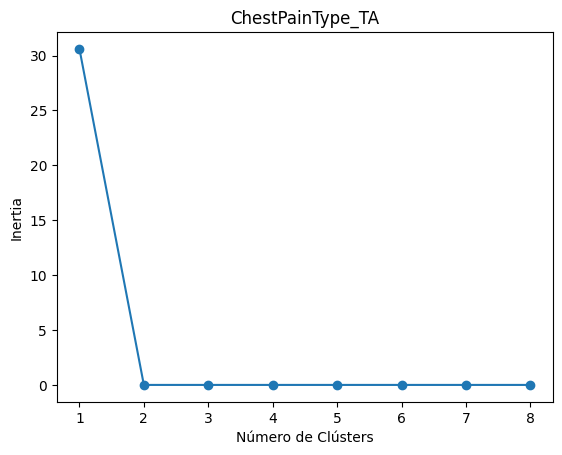

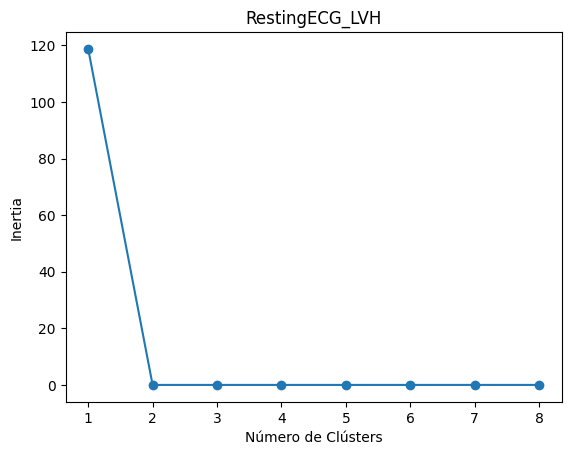

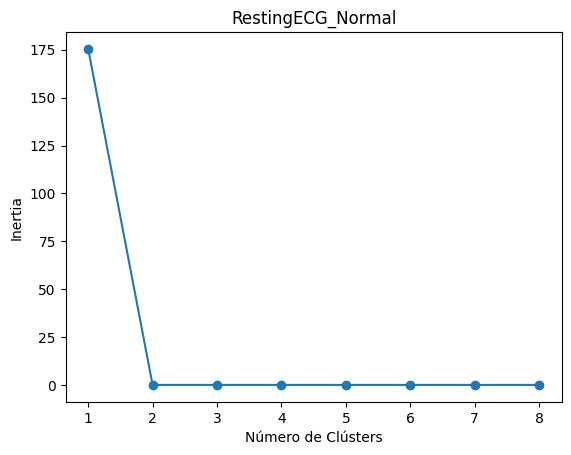

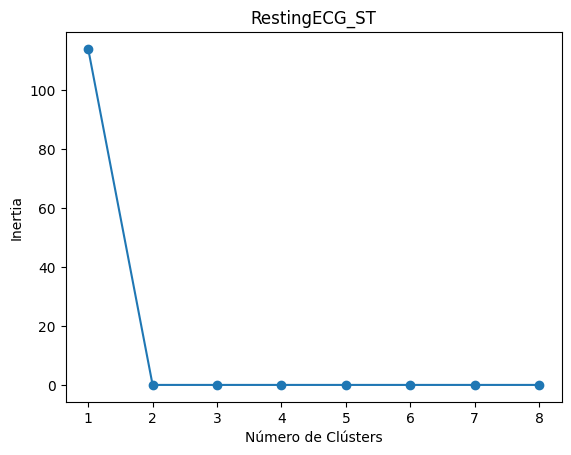

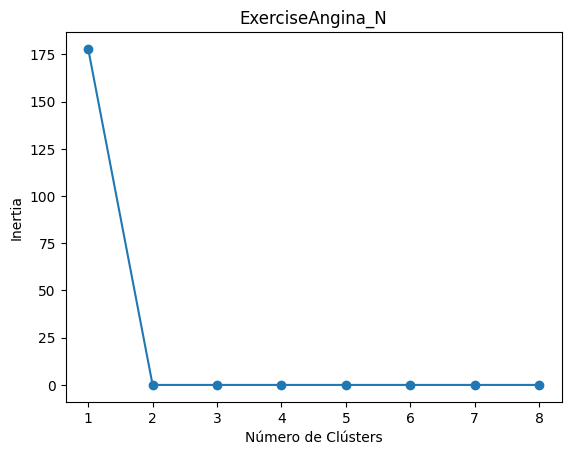

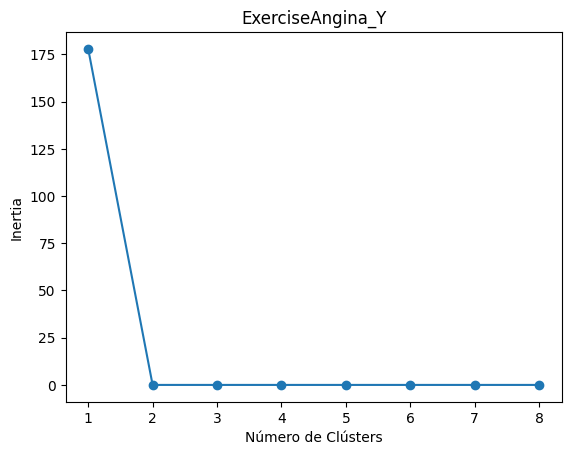

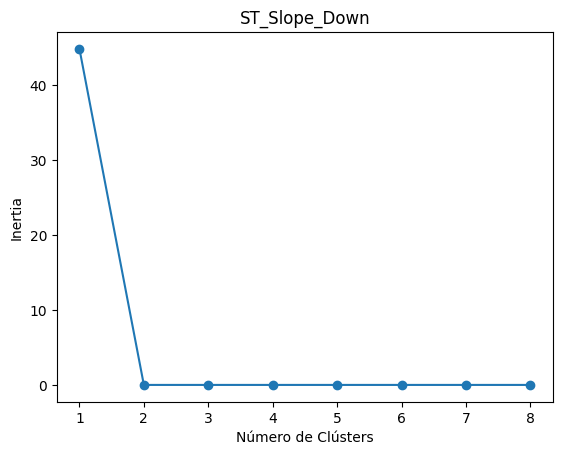

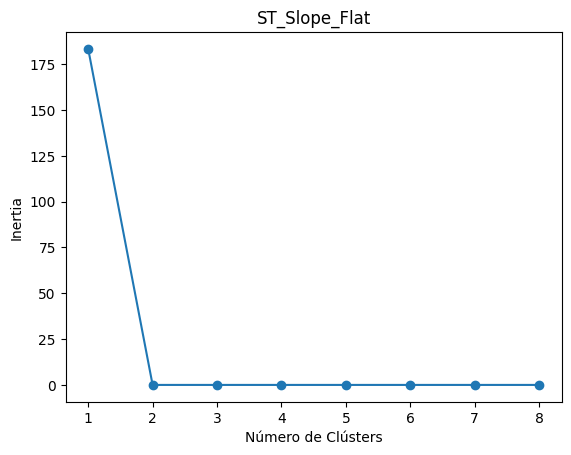

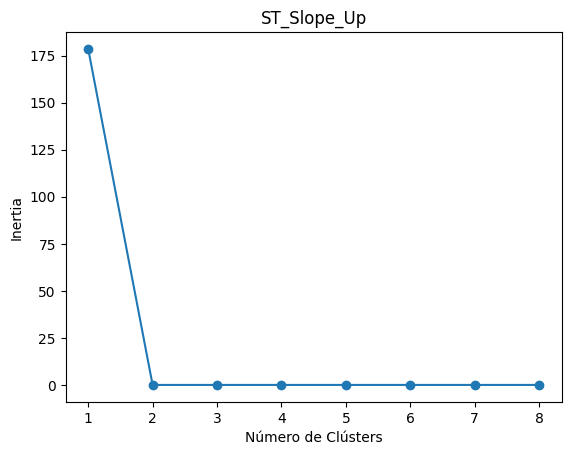

In [ ]:
for col in columns:
  column_data = X_train[col].values.reshape(-1, 1)
  warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
  # Ajustar KMeans con un rango de números de clusters
  inertia_values = []
  possible_clusters = range(1, 9)

  for k in possible_clusters:
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans.fit(column_data)
      inertia_values.append(kmeans.inertia_)

  # Elbow curve plot
  plt.plot(possible_clusters, inertia_values, marker='o')
  plt.xlabel('Número de Clústers')
  plt.ylabel('Inertia')
  plt.title(col)
  plt.show()

Inertia K=1: 8584080.670299724
Inertia K=2: 1842108.9584415657
Inertia K=3: 729931.5141545681
Inertia K=4: 430562.8373540452
Inertia K=5: 287982.5794878349
Inertia K=6: 187562.13216292483
Inertia K=7: 142377.70651826565
Inertia K=8: 107695.67296104923


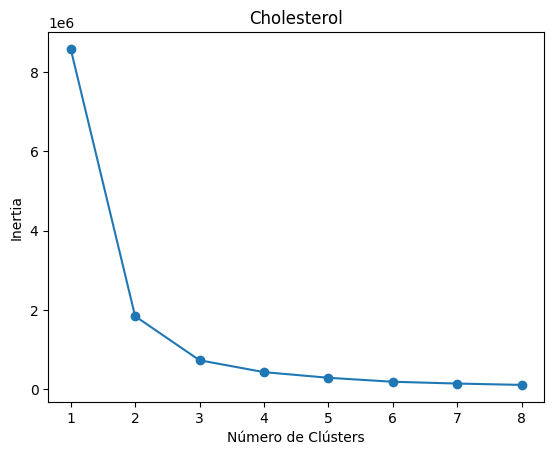

Number of bins: 2
Silhouette score: 0.7914942270592769


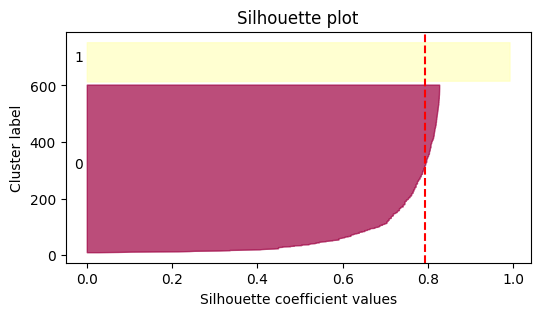

Number of bins: 3
Silhouette score: 0.6546199343159316


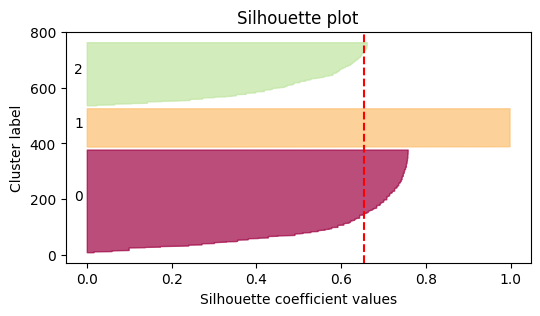

Number of bins: 4
Silhouette score: 0.6441070157573415


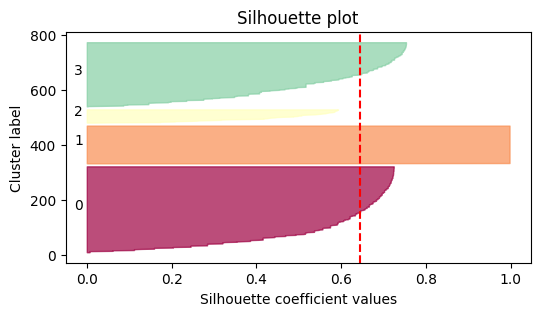

In [ ]:
column_data = X_train["Cholesterol"].values.reshape(-1, 1)

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
inertia_values = []
possible_clusters = range(1, 9)

for k in possible_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(column_data)
    inertia_values.append(kmeans.inertia_)

for k in possible_clusters:
    inertia = str(inertia_values[k-1])
    print("Inertia K=" + str(k) + ": " + inertia)

# Elbow curve plot
plt.plot(possible_clusters, inertia_values, marker='o')
plt.xlabel('Número de Clústers')
plt.ylabel('Inertia')
plt.title('Cholesterol')
plt.show()

def plot_silhouette_analysis(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)

    # Silhouette scores
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)

    fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))

    # Silhouette plot
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    print("Number of bins: " + str(n_clusters))
    print("Silhouette score: " + str(silhouette_avg))
    plt.show()

for n_clusters in range(2, 5):
    plot_silhouette_analysis(column_data, n_clusters)

Tras ejecutar el metodo "Elbow curve" se puede apreciar que hay tres fuertes candidatos para ser el valor óptimo de k: 2, 3 y 4.
A continuación, se ejecuta el metodo "Silhouette score" utilizando los tres diferentes valores mencionados anteriormente.

Los reusltados obtenidos son los siguientes:
  *   k=2: Inertia = 1842108, Silhouette Score = 0.79.
  *   k=3: Inertia = 729931, Silhouette Score = 0.65.
  *   k=4: Inertia = 430562, Silhouette Score = 0.64.

Se realiza una comparación entre k=2 con k=3 y entre k=3 con k=4.
  *   Incrementar el número de clusters de 2 a 3 implica una reducción del valor de Inertia de un 60.38%, mientras que el coeficiente de Silhouette score disminuye en un 17.72%.
  *   Incrementar el número de clusters de 3 a 4 implica una reducción del valor de Inertia de un 41.01%, y una disminución del Silhouette score de un 1.54%.

Realizando una valoración de los resultados obtenidos por ambos métodos, puede apreciarse que el Silhouette score cuando k es igual a dos es ampliamente superior al Silhouette score cuando k vale tres o cuatro. La alta cohesion de los puntos de un mismo cluster compensa el mayor valor de Inertia. Por lo tanto, se decide utilizar un número de clusters igual a 2 para el atributo "Cholesterol".

Se aplica el mismo procedimiento para el resto de atributos.

In [ ]:
unique_values_columns = X_train.nunique()
clusters_per_feature  = [3, 3, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
features_names = X_train.columns
clusters_per_feature_series = pd.Series(clusters_per_feature, index=features_names)
print(unique_values_columns)

Age                   47
RestingBP             60
Cholesterol          203
FastingBS              2
MaxHR                115
Oldpeak               49
Sex_F                  2
Sex_M                  2
ChestPainType_ASY      2
ChestPainType_ATA      2
ChestPainType_NAP      2
ChestPainType_TA       2
RestingECG_LVH         2
RestingECG_Normal      2
RestingECG_ST          2
ExerciseAngina_N       2
ExerciseAngina_Y       2
ST_Slope_Down          2
ST_Slope_Flat          2
ST_Slope_Up            2
dtype: int64


Se define una funcion para crear un data transformer, donde para cada atributo se genera un KBinsDiscretizer.

In [ ]:
def k_bins_discretizer(data, clusters_per_feature_series):
  transformers = []

  for column_name in columns:
    column = X_train[column_name]
    if ((column.dtype == 'float64') or (unique_values_columns[column_name] > 20)):
      transformer_name = 'discretize_' + column_name.replace('_', '')
      transformer = (transformer_name,
                      KBinsDiscretizer(n_bins=clusters_per_feature_series[column_name], encode='ordinal', strategy='kmeans'),
                      [column_name])
      transformers.append(transformer)

  discretizer = ColumnTransformer(
  transformers=transformers,
  remainder='passthrough',
  verbose_feature_names_out=False,
  ).set_output(transform="pandas")

  discretizer.fit(X_train)
  return discretizer

In [ ]:
discretizer = k_bins_discretizer(X_train, clusters_per_feature_series)

X_train_indexes = X_train.index
X_test_indexes = X_test.index

X_train = discretizer.transform(X_train)
X_test = discretizer.transform(X_test)

Se aplica normalización con el fin de llevar todos los valores a una misma escala, y así poder comprarar varianzas.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_indexes, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_indexes, columns=X_test.columns)

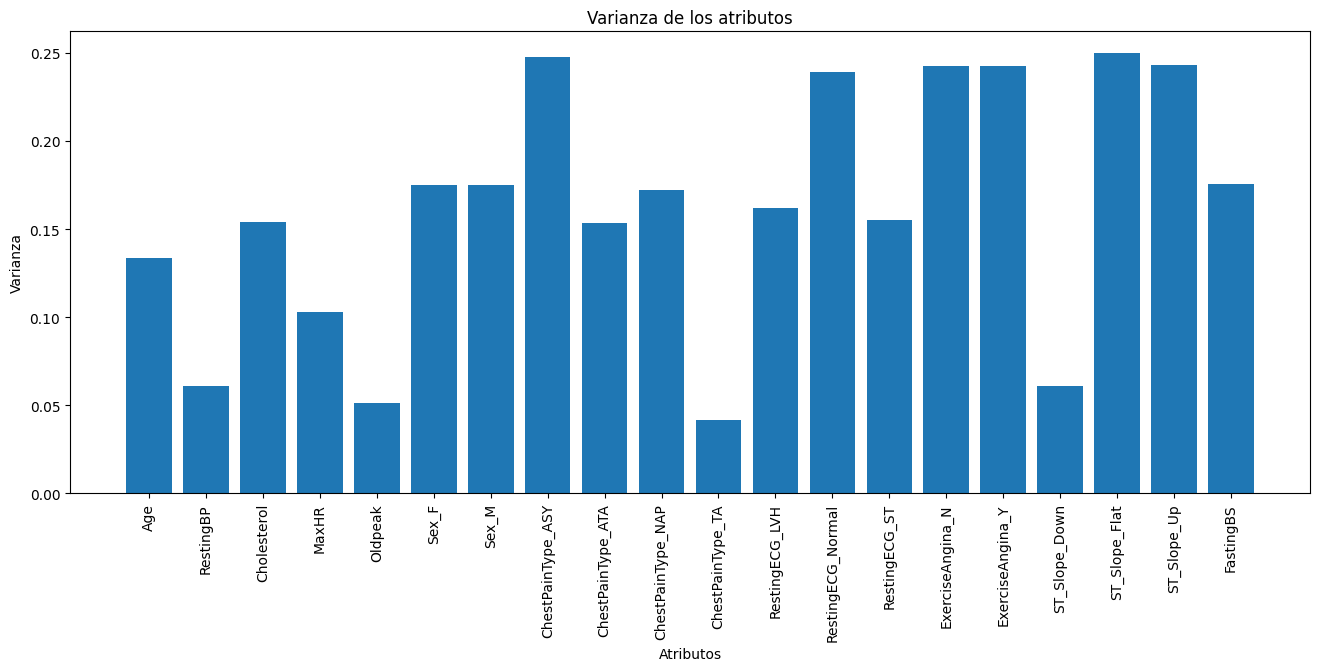

In [ ]:
# Cálculo de varianza
variance_values = np.var(X_train, axis=0)

# Plot
plt.figure(figsize=(16, 6))
plt.bar(X_train.columns, variance_values)
plt.title('Varianza de los atributos')
plt.xlabel('Atributos')
plt.ylabel('Varianza')
plt.xticks(rotation='vertical')
plt.show()

Se construye una matriz de correlación con el fin de estudiar las relaciones lineales entre los atributos y el atributo objetivo, asi como también las relaciones lineales entre atributos predictores.  

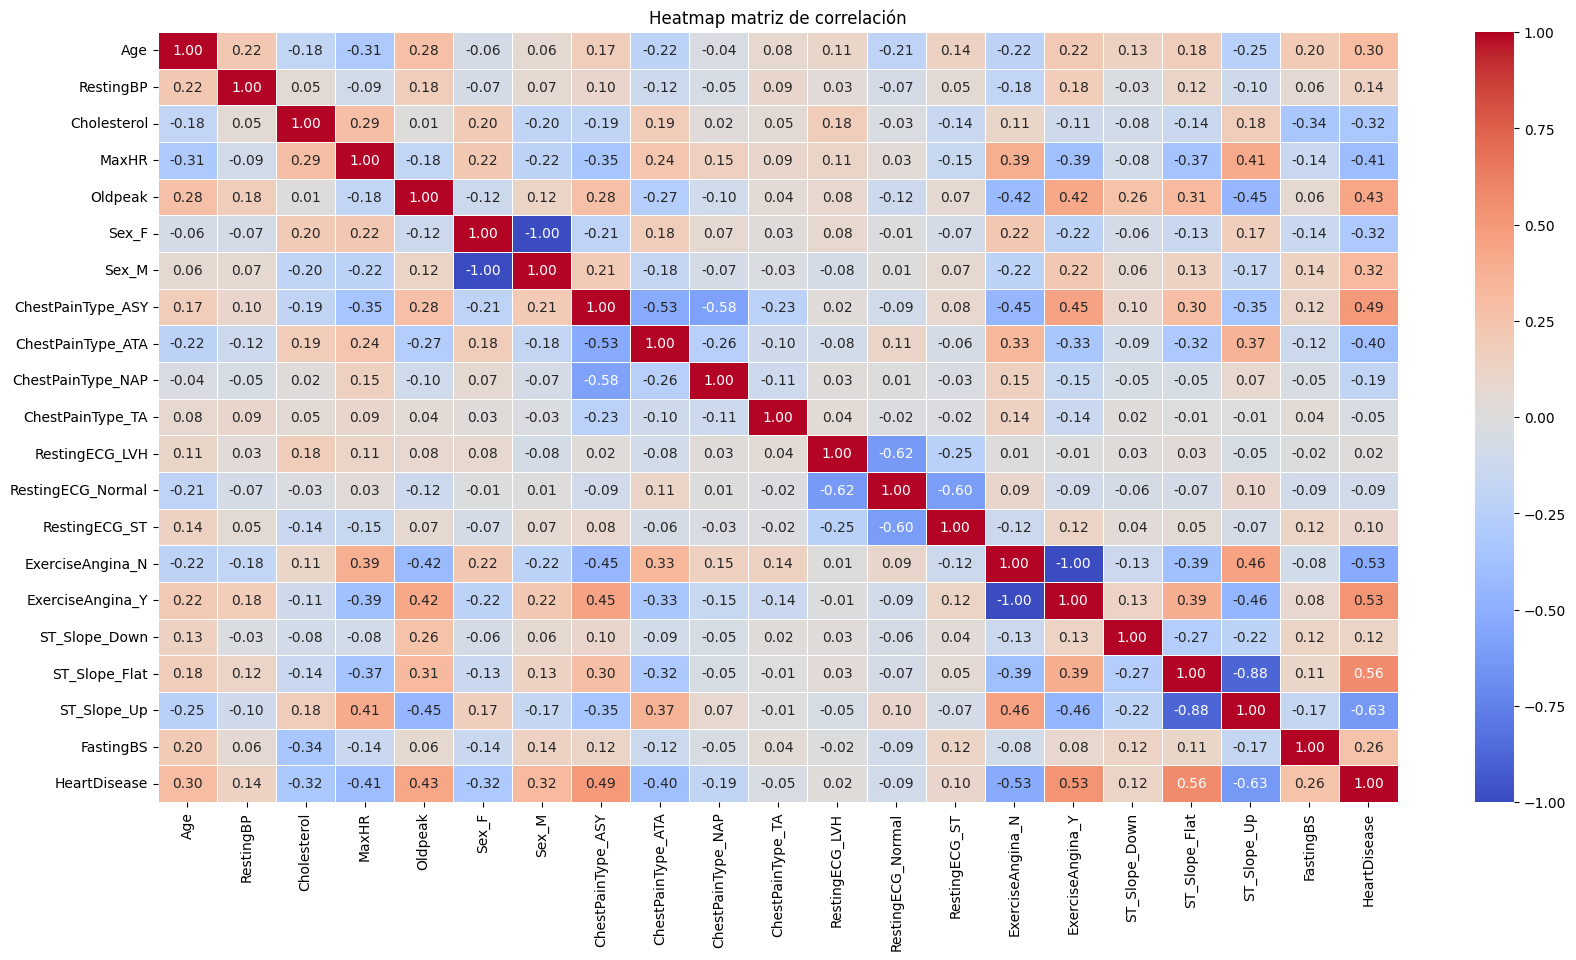

In [ ]:
X_train["HeartDisease"] = y_train
correlation_matrix = X_train.corr()

# Heatmap plot
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap matriz de correlación")
plt.show()

Se eliminan aquellos atributos con un coeficiente de correlación bajo (<0.20) con respecto al atributo objetivo (HeartDisease).

In [ ]:
# Identificar los atributos a eliminar basándose en el umbral
features_to_drop = ["RestingBP", "ChestPainType_NAP", "ChestPainType_TA", "RestingECG_LVH", "RestingECG_Normal", "RestingECG_ST", "ST_Slope_Down"]

# Eliminar los atributos identificados
train_data = X_train.drop(columns=features_to_drop)

test_data = X_test.drop(columns=features_to_drop)
test_data["HeartDisease"] = y_test

train_data.head()


,Age,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,FastingBS,HeartDisease
795,0.0,1.0,1.000000,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
25,0.0,1.0,1.000000,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
84,0.5,1.0,0.333333,0.666667,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1
10,0.0,1.0,0.666667,0.333333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
344,0.5,0.0,0.000000,0.333333,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1


## Construcción del modelo, entrenamiento y testeo:

Se utiliza el estimador de Laplace con el fin de evitar problemas asociados con probabilidades condicionales iguales a cero en los datos. Esto se debe a que si en el conjunto de entrenamiento no se ha observado ninguna entrada que tenga el valor $x$ para determinado atributo y al mismo tiempo un valor del atributo target igual a $y$, se tendrá que $P(x|y)$ = 0. Utilizando el estimador de Laplace se tiene que:
$\text{P(x|y)} = \frac{n_x + \alpha}{N_y + \alpha K} $, donde:

  *   $n_x$ es el número de veces que el evento $x$ ocurre en los datos,
  *   $\alpha$ es el parámetro de suavizado de Laplace,
  *   $N_y$ representa la cantidad de veces que el atributo target toma el valor y,
  *   $K$ es el número de atributos.

In [ ]:
element_counts = train_data["HeartDisease"].value_counts()
columns_modified = train_data.drop("HeartDisease", axis=1).columns
num_rows = train_data.shape[0]

alpha = 1
count_target_zero = element_counts[0]
count_target_one = element_counts[1]

conditional_probabilities = {}
conditional_probabilities_zero = {}
conditional_probabilities_one = {}
probability_target_zero = count_target_zero / num_rows
probability_target_one = count_target_one / num_rows

train_data_rows_size = train_data.shape[0]

for col in columns_modified:
  col_value_probability_zero = {}
  col_value_probability_one = {}
  unique_values_feature = train_data[col].unique().tolist()
  for value in unique_values_feature:
    count = len(train_data[(train_data[col] == value) & (train_data['HeartDisease'] == 0)])
    laplace = ((count + alpha) / (count_target_zero + alpha * len(unique_values_feature)))
    col_value_probability_zero[value] = laplace
    conditional_probabilities_zero[col] = col_value_probability_zero

  for value in unique_values_feature:
    count = len(train_data[(train_data[col] == value) & (train_data['HeartDisease'] == 1)])
    laplace = ((count + alpha) / (count_target_one + alpha * len(unique_values_feature)))
    col_value_probability_one[value] = laplace
    conditional_probabilities_one[col] = col_value_probability_one

column_names = list(conditional_probabilities_zero.keys())

print(column_names)

['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up', 'FastingBS']


In [ ]:
X_train = train_data.iloc[:,:-1]
y_train = train_data[['HeartDisease']]

X_test = test_data.iloc[:,:-1]
y_test = test_data[['HeartDisease']]

y_pred = []
row_indices = X_test.index

for row in row_indices:
  accumulative_probability_zero = 1
  accumulative_probability_one = 1
  for col in X_test.columns:
    value = X_test.loc[row, col]

    conditional_prob_col_zero = conditional_probabilities_zero.get(col)
    col_val_probability_zero = conditional_prob_col_zero.get(value, "error")

    conditional_prob_col_one = conditional_probabilities_one.get(col)
    col_val_probability_one = conditional_prob_col_one.get(value, "error")

    if (col_val_probability_zero == "error"):
      accumulative_probability_zero *= ((1 + alpha) / (count_target_zero + alpha * len(columns_modified)))
    else:
      accumulative_probability_zero *= col_val_probability_zero

    if (col_val_probability_one == "error"):
      accumulative_probability_one *= ((1 + alpha) / (count_target_one + alpha * len(columns_modified)))
    else:
      accumulative_probability_one *= col_val_probability_one

  accumulative_probability_zero *= probability_target_zero
  accumulative_probability_one *= probability_target_one

  if accumulative_probability_zero > accumulative_probability_one:
    y_pred.append(0)
  else:
    y_pred.append(1)


Se evalúa el rendimiento del modelo sobre el conjunto de prueba (X_test).

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
metrics_info = metrics.classification_report(y_test, y_pred)

print(accuracy)
print(metrics_info)

0.8586956521739131
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.91      0.84      0.87       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



Ahora se evalúa el rendimiento utilizando MultinomialNB() de sklearn.naive_bayes.

In [ ]:
# Clasificador Naive Bayes Multinomial
model = MultinomialNB()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
metrics_info = metrics.classification_report(y_test, predictions)

print(accuracy)
print(metrics_info)
print("Accuracy:", accuracy)

0.8369565217391305
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        77
           1       0.88      0.83      0.86       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184

Accuracy: 0.8369565217391305
